[![OpenStreetMap](https://openrouteservice.org/wp-content/uploads/2018/01/openstreetmap-2.png)](https://www.openstreetmap.org)

## Import modules

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import json
import zipfile
from shapely.geometry import Point

## Helper functions

In [2]:
def get_data(area, key, value):
    """
    area   : https://en.wikipedia.org/wiki/ISO_3166-2
    amenity: https://wiki.openstreetmap.org/wiki/Key:amenity?uselang=en-US
    """
    url = "http://overpass-api.de/api/interpreter"
    query ="""
    [out:json];
    area["ISO3166-1"="{0}"][admin_level=2];
    (node["{1}"="{2}"](area);
     way["{1}"="{2}"](area);
     rel["{1}"="{2}"](area);
    );
    out center;
    """.format(area, key, value)
    response = requests.get(url, params={'data': query})
    return response.json()

In [3]:
def get_coords(data):
    coords = []
    for element in data['elements']:
        if element['type'] == 'node':
            lon = element['lon']
            lat = element['lat']
            coords.append((lon, lat))
        elif 'center' in element:
            lon = element['center']['lon']
            lat = element['center']['lat']
            coords.append((lon, lat))
    return coords

## Municipality geodata

In [4]:
url = 'https://www.imergis.nl/gpkg/2019_voorlopige_bestuurlijke_grenzen_imergis_gpkg.zip'
r = requests.get(url)
with open(url.split('/')[-1], 'wb') as file:
    file.write(r.content)

In [5]:
zip_ref = zipfile.ZipFile(url.split('/')[-1], 'r')
zip_ref.extractall()
zip_ref.close()

In [6]:
municipality = gpd.read_file('2019_gemeentegrenzen_kustlijn.gpkg')

## OpenStreetMap visualizations

In [7]:
value = 'cinema'

In [8]:
data = get_data('NL', 'amenity', value)
coords = get_coords(data)
coords = [c for c in coords if c[0] > 3] # drop results Netherlands Antilles
print(len(coords), f'data points found for \'{value}\'.')

173 data points found for 'cinema'.


In [9]:
geodata = pd.DataFrame(coords, columns=['lon', 'lat'])
geodata['geometry'] = geodata.apply(lambda g: Point((g.lon, g.lat)), axis=1)
geodata = gpd.GeoDataFrame(geodata, crs={'init': 'epsg:4326'}, geometry=geodata.geometry)
geodata.geometry = geodata.geometry.to_crs(municipality.crs)

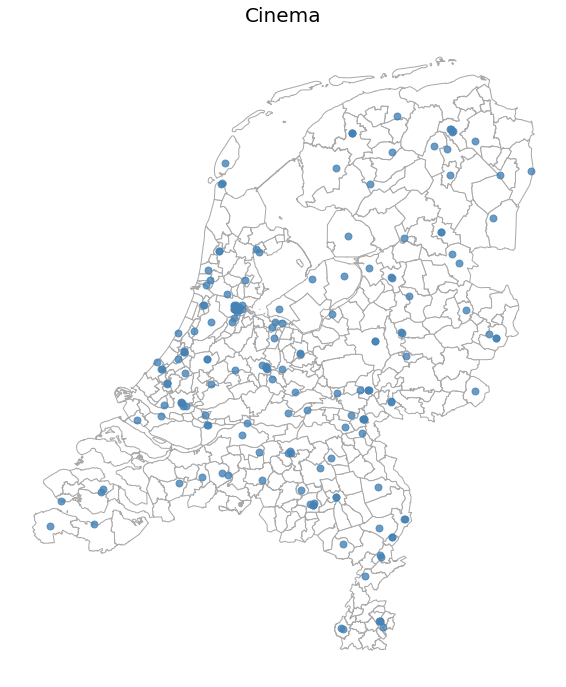

In [10]:
f, ax = plt.subplots(figsize=(12, 12))
municipality.plot(ax=ax, color='white', edgecolor='darkgrey', linewidth=1)
geodata.plot(ax=ax, markersize=48, c='steelblue', alpha=0.8)
plt.title(value.replace('_', ' ').capitalize(), fontsize=20)
plt.axis('off')
plt.show()

In [11]:
counts = gpd.sjoin(municipality, geodata, how='inner', op='intersects')\
.groupby(by='gemeentenaam').size().to_frame('count').reset_index()
counts = pd.merge(municipality, counts, how='left', on='gemeentenaam').fillna(0)
counts['count'] = counts['count'].astype(int)

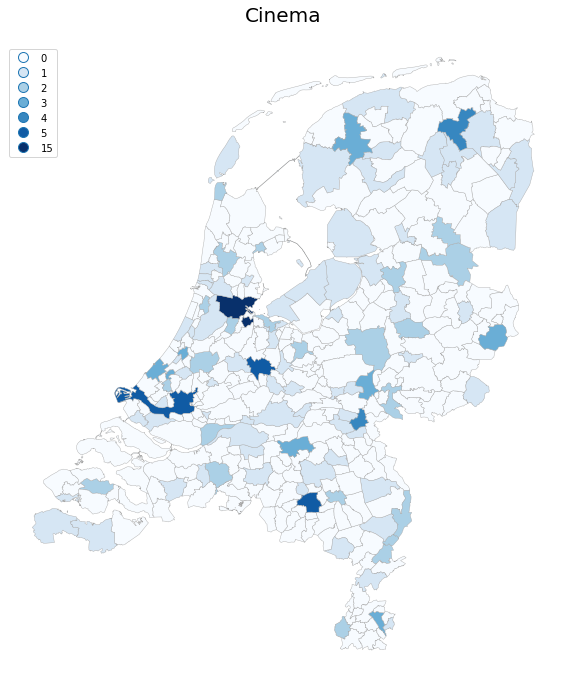

In [12]:
f, ax = plt.subplots(1, figsize=(12, 12))
counts.plot(ax=ax, column='count', cmap='Blues', edgecolor='darkgrey',
            linewidth=0.4, legend=True, categorical=True)
plt.title(value.replace('_', ' ').capitalize(), fontsize=20)
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.1, 0, 0, 0.975))
plt.axis('off')
plt.show()